## Modelo de regresion logistica Base

In [2]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, fbeta_score, roc_curve
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
data_path = "../data/fraud_train.csv"
df = pd.read_csv(data_path)

Se hacen las transformaciones resultado del analisis exploratorio

In [4]:
df = df[
    [
        'Month',
         'DayOfWeek',
         'Make',
         'AccidentArea',
         'MonthClaimed',
         'WeekOfMonthClaimed',
         'MaritalStatus',
         'Fault',
         'PolicyType',
         'VehicleCategory',
         'VehiclePrice',
         'Deductible',
         'PastNumberOfClaims',
         'AgeOfVehicle',
         'AgeOfPolicyHolder',
         'AgentType',
         'NumberOfSuppliments',
         'AddressChange_Claim',
         'BasePolicy',
         'FraudFound_P'
    ]
]

In [5]:
replace_map = {
    'Porche': 'Luxyry',
    'Ferrari': 'Luxyry',
    'Mecedes': 'Luxyry'
}

# Aplica el reemplazo
df_final = df.copy()
df_final['Make'] = df_final['Make'].replace(replace_map)

Creamos los conjuntos de entrenamiento y validacion

In [6]:
X = df_final.drop('FraudFound_P', axis=1)
y = df_final['FraudFound_P']

In [7]:
X, X_val, y, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y 
)

Calculo del scorecard

In [7]:
def generate_scorecard(model, encoder, pdo=20, base_score=600, base_odds=50):
    coef = model.named_steps["model"].coef_[0]
    intercept = model.named_steps["model"].intercept_[0]
    variables = encoder.get_feature_names_out()

    factor = pdo / np.log(2)
    offset = base_score - factor * np.log(base_odds)

    scorecard = []
    for i, var in enumerate(variables):
        scorecard.append({
            "variable": var,
            "coef": coef[i],
            "points_per_unit_woe": -coef[i] * factor
        })
    return scorecard, intercept, factor, offset

def score_from_prob(prob, factor, offset):
    odds = prob / (1 - prob)
    return offset - factor * np.log(odds)

Optimizacion de hiperparametros con optuna para C y max_iter usando como metrica el fbeta score ya que estre prioriza el recall lo cual en un caso de deteccion de fraude es bueno ya que queremos detectar todos los verdaderos positivos a costa de tener algunos falsos positivos

In [8]:
def objective(trial):
    # Hiperparámetros del modelo
    C = trial.suggest_float("C", 0.001, 10.0, log=True)
    max_iter = trial.suggest_int("max_iter", 100, 1000)
    threshold = trial.suggest_float("threshold", 0.01, 0.99)

    pipeline = Pipeline([
        ("woe", ce.WOEEncoder()),
        ("model", LogisticRegression(class_weight="balanced",C=C, max_iter=max_iter, solver="lbfgs"))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


    y_prob = cross_val_predict(pipeline, X, y, cv=cv, method="predict_proba")[:, 1]

    # Aplicar threshold sugerido por Optuna
    y_pred = (y_prob >= threshold).astype(int)

    # Métrica a maximizar
    return fbeta_score(y, y_pred, beta=2)

In [9]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
best_params = study.best_params
print("Mejores params:", best_params)

[I 2025-08-14 04:37:48,096] A new study created in memory with name: no-name-17c854b9-3f17-459b-b41d-921020e3265b
[I 2025-08-14 04:37:49,332] Trial 0 finished with value: 0.2520122652357225 and parameters: {'C': 0.08599273575480698, 'max_iter': 196, 'threshold': 0.030956350211970733}. Best is trial 0 with value: 0.2520122652357225.
[I 2025-08-14 04:37:51,514] Trial 1 finished with value: 0.20770392749244712 and parameters: {'C': 1.6785041891248225, 'max_iter': 541, 'threshold': 0.809225474073377}. Best is trial 0 with value: 0.2520122652357225.
[I 2025-08-14 04:37:55,638] Trial 2 finished with value: 0.19923371647509577 and parameters: {'C': 0.04844955198463652, 'max_iter': 347, 'threshold': 0.7766195361803953}. Best is trial 0 with value: 0.2520122652357225.
[I 2025-08-14 04:37:56,551] Trial 3 finished with value: 0.013979496738117428 and parameters: {'C': 0.0015609755464947013, 'max_iter': 389, 'threshold': 0.740301733809844}. Best is trial 0 with value: 0.2520122652357225.
[I 2025-0

Mejores params: {'C': 0.07147775204296303, 'max_iter': 484, 'threshold': 0.5606630031491324}


Entrenamiento del modelo con los parametros optimos

In [10]:
params = best_params.copy()
params.pop('threshold', None)

pipeline = Pipeline(steps=[
    ("woe", ce.WOEEncoder()),
    ("model", LogisticRegression(**params, class_weight="balanced", solver="lbfgs"))
])

pipeline.fit(X, y)

encoder = pipeline.named_steps["woe"]
scorecard, intercept, factor, offset = generate_scorecard(pipeline, encoder)

y_prob_val = pipeline.predict_proba(X_val)[:, 1]
y_score_val = score_from_prob(y_prob_val, factor, offset)
y_pred_val = (y_prob_val >= 0.5).astype(int)


auc = roc_auc_score(y_val, y_prob_val)
fpr, tpr, _ = roc_curve(y_val, y_prob_val)
ks = max(tpr - fpr)
fb = fbeta_score(y_val, y_pred_val, beta=2)

In [8]:
X_val

,Month,DayOfWeek,Make,AccidentArea,MonthClaimed,WeekOfMonthClaimed,MaritalStatus,Fault,PolicyType,VehicleCategory,VehiclePrice,Deductible,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,AgentType,NumberOfSuppliments,AddressChange_Claim,BasePolicy
1625,Jun,Wednesday,Chevrolet,Urban,Jul,1,Married,Third Party,Sedan - Collision,Sedan,20000 to 29000,400,2 to 4,7 years,36 to 40,External,more than 5,no change,Collision
4186,Feb,Tuesday,Toyota,Urban,Feb,2,Married,Third Party,Sedan - All Perils,Sedan,20000 to 29000,400,1,5 years,31 to 35,External,none,no change,All Perils
1640,Feb,Thursday,Pontiac,Urban,Feb,4,Married,Third Party,Sedan - Collision,Sedan,20000 to 29000,700,1,more than 7,41 to 50,External,3 to 5,no change,Collision
3249,Jun,Saturday,Toyota,Urban,Jun,3,Married,Third Party,Sedan - Liability,Sport,20000 to 29000,400,1,7 years,36 to 40,External,none,no change,Liability
3168,Jun,Saturday,Chevrolet,Urban,Jul,3,Single,Policy Holder,Utility - All Perils,Utility,more than 69000,400,2 to 4,7 years,41 to 50,External,more than 5,1 year,All Perils
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4835,Jun,Wednesday,Toyota,Urban,Jun,4,Married,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,400,none,more than 7,41 to 50,External,none,no change,Collision
3258,Oct,Wednesday,Chevrolet,Urban,Oct,3,Single,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,400,none,6 years,31 to 35,External,1 to 2,4 to 8 years,Collision
3091,Sep,Sunday,Pontiac,Urban,Sep,4,Single,Policy Holder,Sedan - Liability,Sport,20000 to 29000,400,2 to 4,7 years,31 to 35,External,1 to 2,no change,Liability
2852,Nov,Saturday,Pontiac,Urban,Dec,1,Married,Policy Holder,Sedan - Collision,Sedan,30000 to 39000,400,2 to 4,7 years,36 to 40,External,none,no change,Collision


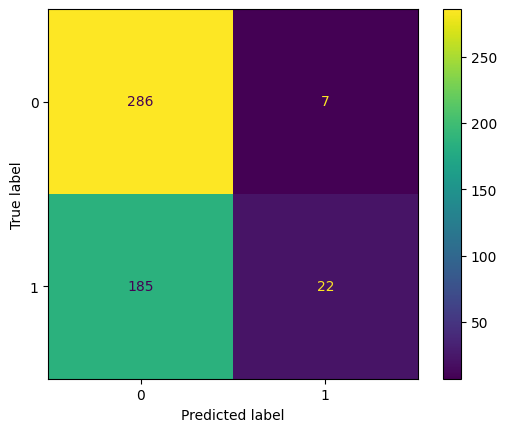

In [11]:
cm = confusion_matrix(y_pred_val, y_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [12]:
print(auc)
print(ks)
print(fb)

0.7748737096419943
0.5111647997657223
0.34055727554179566


In [13]:
pd.DataFrame(scorecard)

,variable,coef,points_per_unit_woe
0,Month,0.657641,-18.975501
1,DayOfWeek,0.686793,-19.816658
2,Make,0.424709,-12.254516
3,AccidentArea,0.461179,-13.306818
4,MonthClaimed,0.467483,-13.488701
5,WeekOfMonthClaimed,0.076478,-2.206675
6,MaritalStatus,0.221989,-6.405259
7,Fault,1.237085,-35.694742
8,PolicyType,0.598216,-17.260871
9,VehicleCategory,-0.220406,6.359573


In [14]:
import pickle

mlflow.set_tracking_uri("http://mlflow:5000")
model_name = 'lr_optimized'
mlflow.set_experiment("fraud_detection")
with mlflow.start_run(run_name=model_name):
    mlflow.log_params(best_params)
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("KS", ks)
    mlflow.log_metric("Fbeta", fb)
    pd.DataFrame(scorecard).to_csv(model_name+"scorecard.csv", index=False)
    with open(model_name+"lr_model.pkl", "wb") as f:
        pickle.dump(pipeline, f)
    mlflow.log_artifact(model_name+"scorecard.csv")
    mlflow.log_artifact(model_name+"lr_model.pkl")
    plt.savefig(model_name+"confusion_matrix.png")
    plt.close()
    mlflow.log_artifact(model_name+"confusion_matrix.png")

🏃 View run lr_optimized at: http://mlflow:5000/#/experiments/1/runs/c50f18ba5796423991c27c9c3fd4b952
🧪 View experiment at: http://mlflow:5000/#/experiments/1
